In [ ]:
!git clone https://github.com/vanshdhar999/TransApp.git

Cloning into 'TransApp'...
remote: Enumerating objects: 758, done.
remote: Counting objects: 100% (346/346), done.
remote: Compressing objects: 100% (184/184), done.
remote: Total 758 (delta 157), reused 332 (delta 151), pack-reused 412 (from 1)
Receiving objects: 100% (758/758), 506.05 MiB | 33.63 MiB/s, done.
Resolving deltas: 100% (310/310), done.
Updating files: 100% (146/146), done.


In [ ]:
# Change to the cloned repository directory
import os
import sys
from pathlib import Path
os.chdir('/content/TransApp')  # Replace with your actual repo name

# Add the repo root to Python path
root = Path(os.getcwd()).resolve()
sys.path.append(str(root))

In [ ]:
!pip install torchinfo

In [ ]:
import os, sys
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn

root = Path(os.getcwd()).resolve().parents[0]
sys.path.append(str(root))
from experiments.data_utils import *
from src.TransAppModel.TransApp import *
from src.AD_Framework.Framework import *
from src.utils.losses import *
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from torch.utils.data import DataLoader, Dataset
from torchinfo import summary

In [ ]:
def get_model_inst(m, win, dim_model, mode="pretraining", large_version=False, path_select_core=None):
    """
    Description:
        Get TransApp model instance

    Parameters:
        m: int - n channel of input time series
        win: int - length of input subsequence (usefull for positional encoding, if any)
        mode: str - 'pretraining' or 'classif' (type of head)
        large_version: boolean - if true, use 5 encoder layers instead of 3
        path_select_core: str - path to pretrained instance of TransApp
    """

    TApp = TransApp(max_len=win, c_in=m,
                    mode=mode,
                    n_embed_blocks=1,
                    encoding_type='noencoding',
                    n_encoder_layers=5 if large_version else 3,
                    kernel_size=5,
                    d_model=dim_model, pffn_ratio=2, n_head=4,
                    prenorm=True, norm="LayerNorm",
                    activation='gelu',
                    store_att=False, attn_dp_rate=0.2, head_dp_rate=0., dp_rate=0.2,
                    att_param={'attenc_mask_diag': True, 'attenc_mask_flag': False, 'learnable_scale_enc': False},
                    c_reconstruct=1, apply_gap=True, nb_class=2)

    if path_select_core is not None:
        TApp.load_state_dict(torch.load(path_select_core)['model_state_dict'])

    return TApp

In [ ]:
m       = 1    # Number of channel of the input time series (i.e. consumption time series, hours encoded in sin/cos based , days encoded in sin/cos based)
win     = 1024 # Choseen length of slicing window size
d_model = 32  # Inner dimension of the model

TransAppInstance = get_model_inst(m=m, win=win, dim_model=d_model, mode="pretraining") # Pretraining mode of our TransApp model

In [ ]:
# data_pretraining = CER_get_data_pretraining(exo_variable=['hours_cos', 'hours_sin', 'days_cos', 'days_sin'])
data_pretraining = COMSTOCK_get_data_pretraining(resolution="15min")

Loaded ComStock 15min data for pretraining: (41, 35040)
Validating ComStock_15min_pretraining...
Found 18248 NaN values, filling with median...
Data validation complete. Shape: (41, 35040) -> (41, 35040)
Applied entire curve normalization
Pretraining data shape: (1394, 1, 1024)


In [ ]:
dict_params = {'lr': 1e-4, 'wd': 1e-4, 'batch_size': 16, 'epochs': 10}
save_path = str(root) + '/tmp/TransAppPT' # Model save path

pretraining_dataset = TSDataset(data_pretraining, scaler=True, scale_dim=[0])
train_loader = torch.utils.data.DataLoader(pretraining_dataset, batch_size=dict_params['batch_size'], shuffle=True)

GeomMask = GeometricMask(mean_length=24, masking_ratio=0.5, type_corrupt='zero', dim_masked=0) # Mask to corrupt inout time series

model_pretrainer = self_pretrainer(TransAppInstance.to("cuda"),
                                   train_loader, valid_loader=None,
                                   learning_rate=dict_params['lr'], weight_decay=dict_params['wd'],
                                   name_scheduler='CosineAnnealingLR',
                                   dict_params_scheduler={'T_max': dict_params['epochs'], 'eta_min': 1e-6},
                                   warmup_duration=None,
                                   criterion=MaskedMSELoss(type_loss='L1'), mask=GeomMask,
                                   device="cuda", all_gpu=False,
                                   verbose=True, plotloss=True,
                                   save_fig=False, path_fig=None,
                                   save_only_core=False,
                                   save_checkpoint=True, path_checkpoint=save_path)

In [ ]:
summary(TransAppInstance, input_size=(1, m, win), mode="train", device='cuda') # show TransApp architecture with pretraining head

Layer (type:depth-idx)                                  Output Shape              Param #
TransApp                                                [1, 1, 1024]              66
├─Sequential: 1-1                                       [1, 1024, 32]             --
│    └─DilatedBlock: 2-1                                [1, 32, 1024]             --
│    │    └─Sequential: 3-1                             [1, 32, 1024]             15,904
│    └─Transpose: 2-2                                   [1, 1024, 32]             --
├─Sequential: 1-2                                       [1, 1024, 32]             --
│    └─EncoderLayer: 2-3                                [1, 1024, 32]             --
│    │    └─LayerNorm: 3-2                              [1, 1024, 32]             64
│    │    └─AttentionLayer: 3-3                         [1, 1024, 32]             4,224
│    │    └─LayerNorm: 3-4                              [1, 1024, 32]             64
│    │    └─PositionWiseFeedForward: 3-5             

Verbose is True if : True
Epoch [1/10]
    Train loss : 0.894062
Verbose is True if : True
Epoch [2/10]
    Train loss : 0.726168
Verbose is True if : True
Epoch [3/10]
    Train loss : 0.680573
Verbose is True if : True
Epoch [4/10]
    Train loss : 0.663443
Verbose is True if : True
Epoch [5/10]
    Train loss : 0.643910
Verbose is True if : True
Epoch [6/10]
    Train loss : 0.629853
Verbose is True if : True
Epoch [7/10]
    Train loss : 0.615800
Verbose is True if : True
Epoch [8/10]
    Train loss : 0.611415
Verbose is True if : True
Epoch [9/10]
    Train loss : 0.608326
Verbose is True if : True
Epoch [10/10]
    Train loss : 0.615296


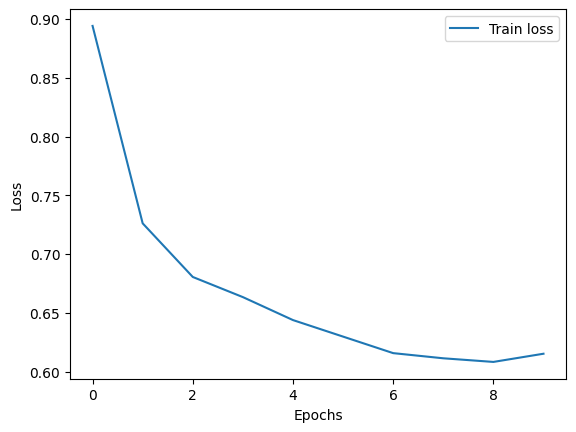

In [ ]:
model_pretrainer.train(dict_params['epochs'])

## Finetuning the pretrained model for Appliance Detection (i.e., a chosen classification case)

In [ ]:

TransAppInstance.mode = "classif" # Change the mode of the TransApp architecture, i.e. use a classification head
# OR
#TransAppInstance = get_model_inst(m=m, win=win, dim_model=d_model, mode="classif", path_select_core= str(root) + '/tmp/TransAppPT.pt') # Load previous pretrained instance

summary(TransAppInstance, input_size=(1, m, win), mode="train", device='cuda') # show TransApp architecture with classification head

Layer (type:depth-idx)                                  Output Shape              Param #
TransApp                                                [1, 2]                    33
├─Sequential: 1-1                                       [1, 1024, 32]             --
│    └─DilatedBlock: 2-1                                [1, 32, 1024]             --
│    │    └─Sequential: 3-1                             [1, 32, 1024]             15,904
│    └─Transpose: 2-2                                   [1, 1024, 32]             --
├─Sequential: 1-2                                       [1, 1024, 32]             --
│    └─EncoderLayer: 2-3                                [1, 1024, 32]             --
│    │    └─LayerNorm: 3-2                              [1, 1024, 32]             64
│    │    └─AttentionLayer: 3-3                         [1, 1024, 32]             4,224
│    │    └─LayerNorm: 3-4                              [1, 1024, 32]             64
│    │    └─PositionWiseFeedForward: 3-5             

In [ ]:
case = 'fans_case' # exemple of detecting cooker in consumption series

# datas_tuple = CER_get_data_case('cooker_case', seed=0, exo_variable=['hours_cos', 'hours_sin', 'days_cos', 'days_sin'], win=win)
datas_tuple = COMSTOCK_get_data_case('cooling_case', seed = 0 )

Loaded ComStock 15min data: (41, 35040)
Loaded cooling_case labels: (1000, 1)
Merged data shape: (41, 35041)
Class ratio: 0.389, Equalize classes: True
Final shapes - Train: (535, 1, 1024), Valid: (238, 1, 1024), Test: (306, 1, 1024)


In [ ]:


dict_params = {'lr': 1e-4, 'wd': 1e-3, 'batch_size': 16, 'epochs': 10, 'p_es': 5, 'p_rlr': 3, 'n_warmup_epochs': 1}
save_path = str(root) + '/tmp/TransAppPTFinetuned_Comstock'

# Sliced data for training
X_train = datas_tuple[0]
y_train = datas_tuple[1]
X_valid = datas_tuple[2]
y_valid = datas_tuple[3]
X_test  = datas_tuple[4]
y_test  = datas_tuple[5]


# Entire curves data for evaluate the model
X_train_voter = datas_tuple[6]
y_train_voter = datas_tuple[7]
X_valid_voter = datas_tuple[8]
y_valid_voter = datas_tuple[9]
X_test_voter  = datas_tuple[10]
y_test_voter  = datas_tuple[11]

# Dataset
train_dataset = TSDataset(X_train, y_train, scaler=True, scale_dim=[0])
valid_dataset = TSDataset(X_valid, y_valid, scaler=True, scale_dim=[0])
test_dataset  = TSDataset(X_test,  y_test,  scaler=True, scale_dim=[0])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=dict_params['batch_size'], shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1, shuffle=True)

# AD Framework trainer
model_trainer = AD_Framework(TransAppInstance,
                             train_loader=train_loader, valid_loader=valid_loader,
                             learning_rate=dict_params['lr'], weight_decay=dict_params['wd'],
                             criterion=nn.CrossEntropyLoss(),
                             patience_es=dict_params['p_es'], patience_rlr=dict_params['p_rlr'],
                             f_metrics=getmetrics(),
                             n_warmup_epochs=dict_params['n_warmup_epochs'],
                             scale_by_subseq_in_voter=True, scale_dim=[0],
                             verbose=True, plotloss=True,
                             save_fig=False, path_fig=None,
                             device="cuda", all_gpu=False,
                             save_checkpoint=True, path_checkpoint=save_path)

/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
model_trainer.train(dict_params['epochs'])

************************************Verbose is true************************************
Epoch [1/10]
    Train loss : nan, Train acc : 44.49%
    Valid  loss : nan, Valid  acc : 42.86%


KeyboardInterrupt: 